<h2>Fire analyses</h2>

<h2>1. Import package, input data, and define function</h2>

In [1]:
# PACKAGE
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pymannkendall as mk
import geemap
import ee
from datetime import date
from calendar import monthrange
from statsmodels.tools.eval_measures import rmse
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

# Authenticate and Initialize GEE
# ee.Authenticate()
ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [2]:
# FUNCTINON
def rmse_fnc(data1,data2):
    x = sm.add_constant(data1)
    y = data2
    mlr = sm.OLS(y,x).fit()
    y_pred = mlr.predict(x)
    rmse_ = rmse(y,y_pred)
    return rmse_

<h2>2. Pre-processing inputs</h2>

In [ ]:
# EC data
EC_N = (pd.read_csv('./Data/EC north data.csv').set_index(pd.date_range(start="2011-10-01",end="2022-10-31",freq="MS",inclusive="left")).rename(columns={'ET':'EC_north'}))
EC_S = (pd.read_csv('./Data/EC south data.csv').set_index(pd.date_range(start="2011-10-01",end="2022-10-31",freq="MS",inclusive="left")).rename(columns={'ET':'EC_south'}))

# GEE

# Tower location
Tower_location = ee.Geometry.Point([115.71365, -31.37641])

# Add map
Map = geemap.Map()

# Upload (for CMRSET)
Tower_whole = geemap.shp_to_ee('Shapefile/Tower_footprint.shp')
Tower_north = geemap.shp_to_ee('Shapefile/Tower_north_footprint.shp')
Tower_south = geemap.shp_to_ee('Shapefile/Tower_south_footprint.shp')

# Upload (for MOD16 and PML)
Tower_pixelContribution = geemap.shp_to_ee('Shapefile/Tower_pixelContribution.shp')
Tower_north_adjacent_1 = ee.Feature(Tower_pixelContribution.toList(Tower_pixelContribution.size()).get(0))
Tower_north_adjacent_2 = ee.Feature(Tower_pixelContribution.toList(Tower_pixelContribution.size()).get(1))
Tower_north_adjacent_3 = ee.Feature(Tower_pixelContribution.toList(Tower_pixelContribution.size()).get(2))
Tower_south_adjacent_1 = ee.Feature(Tower_pixelContribution.toList(Tower_pixelContribution.size()).get(3))
Tower_south_adjacent_2 = ee.Feature(Tower_pixelContribution.toList(Tower_pixelContribution.size()).get(4))
Tower_south_adjacent_3 = ee.Feature(Tower_pixelContribution.toList(Tower_pixelContribution.size()).get(5))

# Contributing area
Tower_pixelContribution_cal = gpd.read_file('Shapefile/Tower_pixelContribution.shp')[['fid','Location','Area']]
Tower_pixelContribution_cal['Ratio'] = np.nan
for x in range(len(Tower_pixelContribution_cal)):
    if x <= 2:
        Tower_pixelContribution_cal.iloc[x,3] = (Tower_pixelContribution_cal.iloc[x,2] / 
                                                 Tower_pixelContribution_cal.groupby(['Location'])['Area'].agg(['sum']).loc[['North'],['sum']].iloc[0])
    else:
        Tower_pixelContribution_cal.iloc[x,3] = (Tower_pixelContribution_cal.iloc[x,2] / 
                                                 Tower_pixelContribution_cal.groupby(['Location'])['Area'].agg(['sum']).loc[['South'],['sum']].iloc[0])

# Arguments to filter the image collection
# Start date
start_date = '2011-10-01'
startDate = ee.Date.parse('YYYY-MM-dd',start_date)
# End date
end_date = '2022-11-01'
endDate = ee.Date.parse('YYYY-MM-dd',end_date)

# Functions
# Clip function
def clip_fnc(image):
    return image.clip(Tower_whole.geometry())

# Count band function
def count_band_fnc(image):
    band_no_var = image.bandNames().size()
    return image.copyProperties(image).set({'band_no':band_no_var})

# Count properties function
def count_property_fnc(image):
    property_no_var = image.propertyNames().size()
    return image.set({'property_no':property_no_var})

# Extract bit function
def bitWiseExtract(input, fromBit, toBit):
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return input.rightShift(fromBit).bitwiseAnd(mask)

# Pixel area function
def pixel_area_fnc(image):
    pixel_area_var = ee.Image.pixelArea()
    image_to_use_var = image.select(0)
    image_to_use_mask = image_to_use_var.gt(0)
    image_to_use_area = pixel_area_var.updateMask(image_to_use_mask)
    area_var = image_to_use_area.reduceRegion(reducer = ee.Reducer.sum(), geometry = Tower_whole.geometry())
    return image.set({'pixel_area':area_var.get('area')})

# CMRSET

# Define QA function
def cmrset_QA_fnc(image):
    cmrset_qa_var = image.select('pixel_qa')
    cmrset_mask_var = bitWiseExtract(cmrset_qa_var,0,1).eq(3)
    return image.updateMask(cmrset_mask_var)

# Filter collection
cmrset = (ee.ImageCollection('TERN/AET/CMRSET_LANDSAT_V2_2')
          .filterBounds(Tower_whole.geometry())
          .filterDate(start_date,end_date)
          .select([0,1],["ET","pixel_qa"])
          .map(cmrset_QA_fnc)
          .map(lambda image: image.set({'ET_north_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_north.geometry(), scale = 30, maxPixels = 1e9).get('ET')}))
          .map(lambda image: image.set({'ET_south_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_south.geometry(), scale = 30, maxPixels = 1e9).get('ET')}))
          .map(count_property_fnc)
          .filterMetadata('property_no','equals',11))

# Generate a dataframe
cmrset_df = pd.DataFrame(list(zip(cmrset.aggregate_array('system:time_start').getInfo(), 
                                  cmrset.aggregate_array('ET_north_value').getInfo(), 
                                  cmrset.aggregate_array('ET_south_value').getInfo())), columns=['Datetime','ET_north','ET_south'])

# Mannually add measurement of 2012-11-01
cmrset_df = (pd.concat([cmrset_df,pd.DataFrame({'Datetime':[1351728000000],'ET_north':[np.nan],'ET_south':[2.5884311434115035]})],ignore_index=True)
             .sort_values(['Datetime'])
             .reset_index(drop=True)
             .set_index(pd.date_range(start="2011-10-01",end="2022-10-31",freq="MS",inclusive="left"))
             .drop(columns=['Datetime'])
             .rename(columns={'ET_north':'CMRSET_north','ET_south':'CMRSET_south'}))

# MOD16A2 (use MOD16A2.006 rather than MOD16A2.061 as the newer only covers from 2021) 

# Define QA function
def mod16a2_QA_fnc(image):
    mod16a2_qa_var = image.select('pixel_qa')
    mod16a2_mask_qc_var = bitWiseExtract(mod16a2_qa_var,0,0).eq(0)
    mod16a2_mask_sensor_var = bitWiseExtract(mod16a2_qa_var,1,1).eq(0)
    mod16a2_mask_cloud_state_var = bitWiseExtract(mod16a2_qa_var,3,4).eq(0)
    mod16a2_mask_confidence_var = bitWiseExtract(mod16a2_qa_var,5,7).lte(1)
    mod16a2_mask_var = mod16a2_mask_qc_var.add(mod16a2_mask_sensor_var).add(mod16a2_mask_cloud_state_var).add(mod16a2_mask_confidence_var)
    return image.updateMask(mod16a2_mask_var)

# Define conversion calculation
def mod16a2_convert(image):
    
    # Converted ET
    et_converted = image.expression('(ET*0.1)/8',{'ET':image.select('ET')}).rename('ET_converted')
    image = image.addBands(et_converted)
    return image

# Filter collection 
mod16a2 = (ee.ImageCollection('MODIS/006/MOD16A2')
           .filterBounds(Tower_whole.geometry())
           .filterDate(start_date,end_date)
           .select([0,4],["ET","pixel_qa"])
           .map(mod16a2_QA_fnc)
           .map(mod16a2_convert))

# Loop 
mod16a2_name_for_loop = ['ET_north_1_value','ET_north_2_value','ET_north_3_value','ET_south_1_value','ET_south_2_value','ET_south_3_value']
mod16a2_file_for_loop = [Tower_north_adjacent_1,Tower_north_adjacent_2,Tower_north_adjacent_3,Tower_south_adjacent_1,Tower_south_adjacent_2,Tower_south_adjacent_2]

for x in range(len(mod16a2_name_for_loop)):
    mod16a2_x = (mod16a2
                 .map(lambda image: image.set({mod16a2_name_for_loop[x]:image.reduceRegion(reducer = ee.Reducer.mean(), 
                                                                                           geometry = mod16a2_file_for_loop[x].geometry(), 
                                                                                           scale = 500, maxPixels = 1e9).get('ET_converted')}))
                 .map(count_property_fnc)
                 .filterMetadata('property_no','equals',11))
    
    if x == 0:
        mod16a2_df = pd.DataFrame(list(zip(mod16a2_x.aggregate_array('system:time_start').getInfo(),
                                          mod16a2_x.aggregate_array(mod16a2_name_for_loop[x]).getInfo())), 
                                  columns=['Datetime',mod16a2_name_for_loop[x]]).set_index('Datetime')
        
    else:
        mod16a2_df = pd.concat([mod16a2_df,pd.DataFrame(list(zip(mod16a2_x.aggregate_array('system:time_start').getInfo(),
                                                                 mod16a2_x.aggregate_array(mod16a2_name_for_loop[x]).getInfo())), 
                                                        columns=['Datetime',mod16a2_name_for_loop[x]]).set_index('Datetime')],axis=1).sort_index()
        
# Fill nan values with data from other columns
mod16a2_df_fillna = mod16a2_df.copy()
mod16a2_df_fillna['ET_north_2_value'] = mod16a2_df_fillna['ET_north_2_value'].fillna(mod16a2_df_fillna['ET_north_1_value'])
mod16a2_df_fillna['ET_north_3_value'] = mod16a2_df_fillna['ET_north_3_value'].fillna(mod16a2_df_fillna['ET_north_2_value'])
mod16a2_df_fillna['ET_south_1_value'] = mod16a2_df_fillna['ET_south_1_value'].fillna(mod16a2_df_fillna['ET_south_2_value'])

# Summary
mod16a2_df_fillna['ET_north'] = (mod16a2_df_fillna['ET_north_1_value'] * Tower_pixelContribution_cal.loc[0,['Ratio']].iloc[0] + 
                                 mod16a2_df_fillna['ET_north_2_value'] * Tower_pixelContribution_cal.loc[1,['Ratio']].iloc[0] + 
                                 mod16a2_df_fillna['ET_north_3_value'] * Tower_pixelContribution_cal.loc[2,['Ratio']].iloc[0])

mod16a2_df_fillna['ET_south'] = (mod16a2_df_fillna['ET_south_1_value'] * Tower_pixelContribution_cal.loc[3,['Ratio']].iloc[0] + 
                                 mod16a2_df_fillna['ET_south_2_value'] * Tower_pixelContribution_cal.loc[4,['Ratio']].iloc[0] + 
                                 mod16a2_df_fillna['ET_south_3_value'] * Tower_pixelContribution_cal.loc[5,['Ratio']].iloc[0])

mod16a2_df_fillna = mod16a2_df_fillna.reset_index()
mod16a2_df_fillna = (mod16a2_df_fillna.set_index(pd.to_datetime(mod16a2_df_fillna['Datetime'],unit='ms'))
                     .drop(['Datetime'],axis=1)
                     .resample('MS').mean()
                     .rename(columns={'ET_north':'MOD16_north','ET_south':'MOD16_south'}))

# PML

# Define summary calculation
def pml_sum(image):
    
    # Summary ET
    et = image.expression('ETc+ETs+ETi',{
        'ETc':image.select('ETc'),
        'ETs':image.select('ETs'),
        'ETi':image.select('ETi')}).rename('ET_sum')
    image = image.addBands(et)
    return image

# Filter collection
pml = (ee.ImageCollection('CAS/IGSNRR/PML/V2_v017')
       .filterBounds(Tower_whole.geometry())
       .filterDate(start_date,end_date)
       .select(["Ec","Es","Ei"],["ETc","ETs","ETi"])
       .map(pml_sum)
       .map(lambda image: image.set({'ET_north_1_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_north_adjacent_1.geometry(), scale = 500, maxPixels = 1e9).get('ET_sum'),
                                     'ET_north_2_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_north_adjacent_2.geometry(), scale = 500, maxPixels = 1e9).get('ET_sum'),
                                     'ET_north_3_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_north_adjacent_3.geometry(), scale = 500, maxPixels = 1e9).get('ET_sum'),
                                     'ET_south_1_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_south_adjacent_1.geometry(), scale = 500, maxPixels = 1e9).get('ET_sum'),
                                     'ET_south_2_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_south_adjacent_2.geometry(), scale = 500, maxPixels = 1e9).get('ET_sum'),
                                     'ET_south_3_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_south_adjacent_3.geometry(), scale = 500, maxPixels = 1e9).get('ET_sum')}))
       .map(count_property_fnc)
       .filterMetadata('property_no','equals',12))

# Generate a dataframe ('system:time_start' has error, use code editor)
pml_df = pd.DataFrame(list(zip(pml.aggregate_array('system:time_start').getInfo(), 
                               pml.aggregate_array('ET_north_1_value').getInfo(), pml.aggregate_array('ET_north_2_value').getInfo(), 
                               pml.aggregate_array('ET_north_3_value').getInfo(), pml.aggregate_array('ET_south_1_value').getInfo(), 
                               pml.aggregate_array('ET_south_2_value').getInfo(), pml.aggregate_array('ET_south_3_value').getInfo())), 
                      columns=['Datetime','ET_north_1','ET_north_2','ET_north_3','ET_south_1','ET_south_2','ET_south_3'])

pml_df = pml_df.set_index(pd.to_datetime(pml_df['Datetime'], unit='ms')).drop(['Datetime'], axis=1).resample('MS').mean()
pml_df['PML_north'] = (pml_df['ET_north_1'] * Tower_pixelContribution_cal.loc[0,['Ratio']].iloc[0] + 
                       pml_df['ET_north_2'] * Tower_pixelContribution_cal.loc[1,['Ratio']].iloc[0] + 
                       pml_df['ET_north_3'] * Tower_pixelContribution_cal.loc[2,['Ratio']].iloc[0])

pml_df['PML_south'] = (pml_df['ET_south_1'] * Tower_pixelContribution_cal.loc[3,['Ratio']].iloc[0] + 
                       pml_df['ET_south_2'] * Tower_pixelContribution_cal.loc[4,['Ratio']].iloc[0] + 
                       pml_df['ET_south_3'] * Tower_pixelContribution_cal.loc[5,['Ratio']].iloc[0])

<h2>3. Combine input</h2>

In [4]:
# Combine input
combine_N = (pd.concat([EC_N['2011-10-01':'2022-10-01'],
                       cmrset_df['2011-10-01':'2022-10-01']['CMRSET_north'],
                       mod16a2_df_fillna['2011-10-01':'2022-10-01']['MOD16_north'],
                       pml_df['2011-10-01':'2022-10-01']['PML_north']],axis=1)
             .rename(columns={'EC_north':'EC','CMRSET_north':'CMRSET','MOD16_north':'MOD16','PML_north':'PML'}))

combine_S = (pd.concat([EC_S['2011-10-01':'2022-10-01'],
                       cmrset_df['2011-10-01':'2022-10-01']['CMRSET_south'],
                       mod16a2_df_fillna['2011-10-01':'2022-10-01']['MOD16_south'],
                       pml_df['2011-10-01':'2022-10-01']['PML_south']],axis=1)
             .rename(columns={'EC_south':'EC','CMRSET_south':'CMRSET','MOD16_south':'MOD16','PML_south':'PML'}))

<h2>4. Analysis before normalisation</h2>

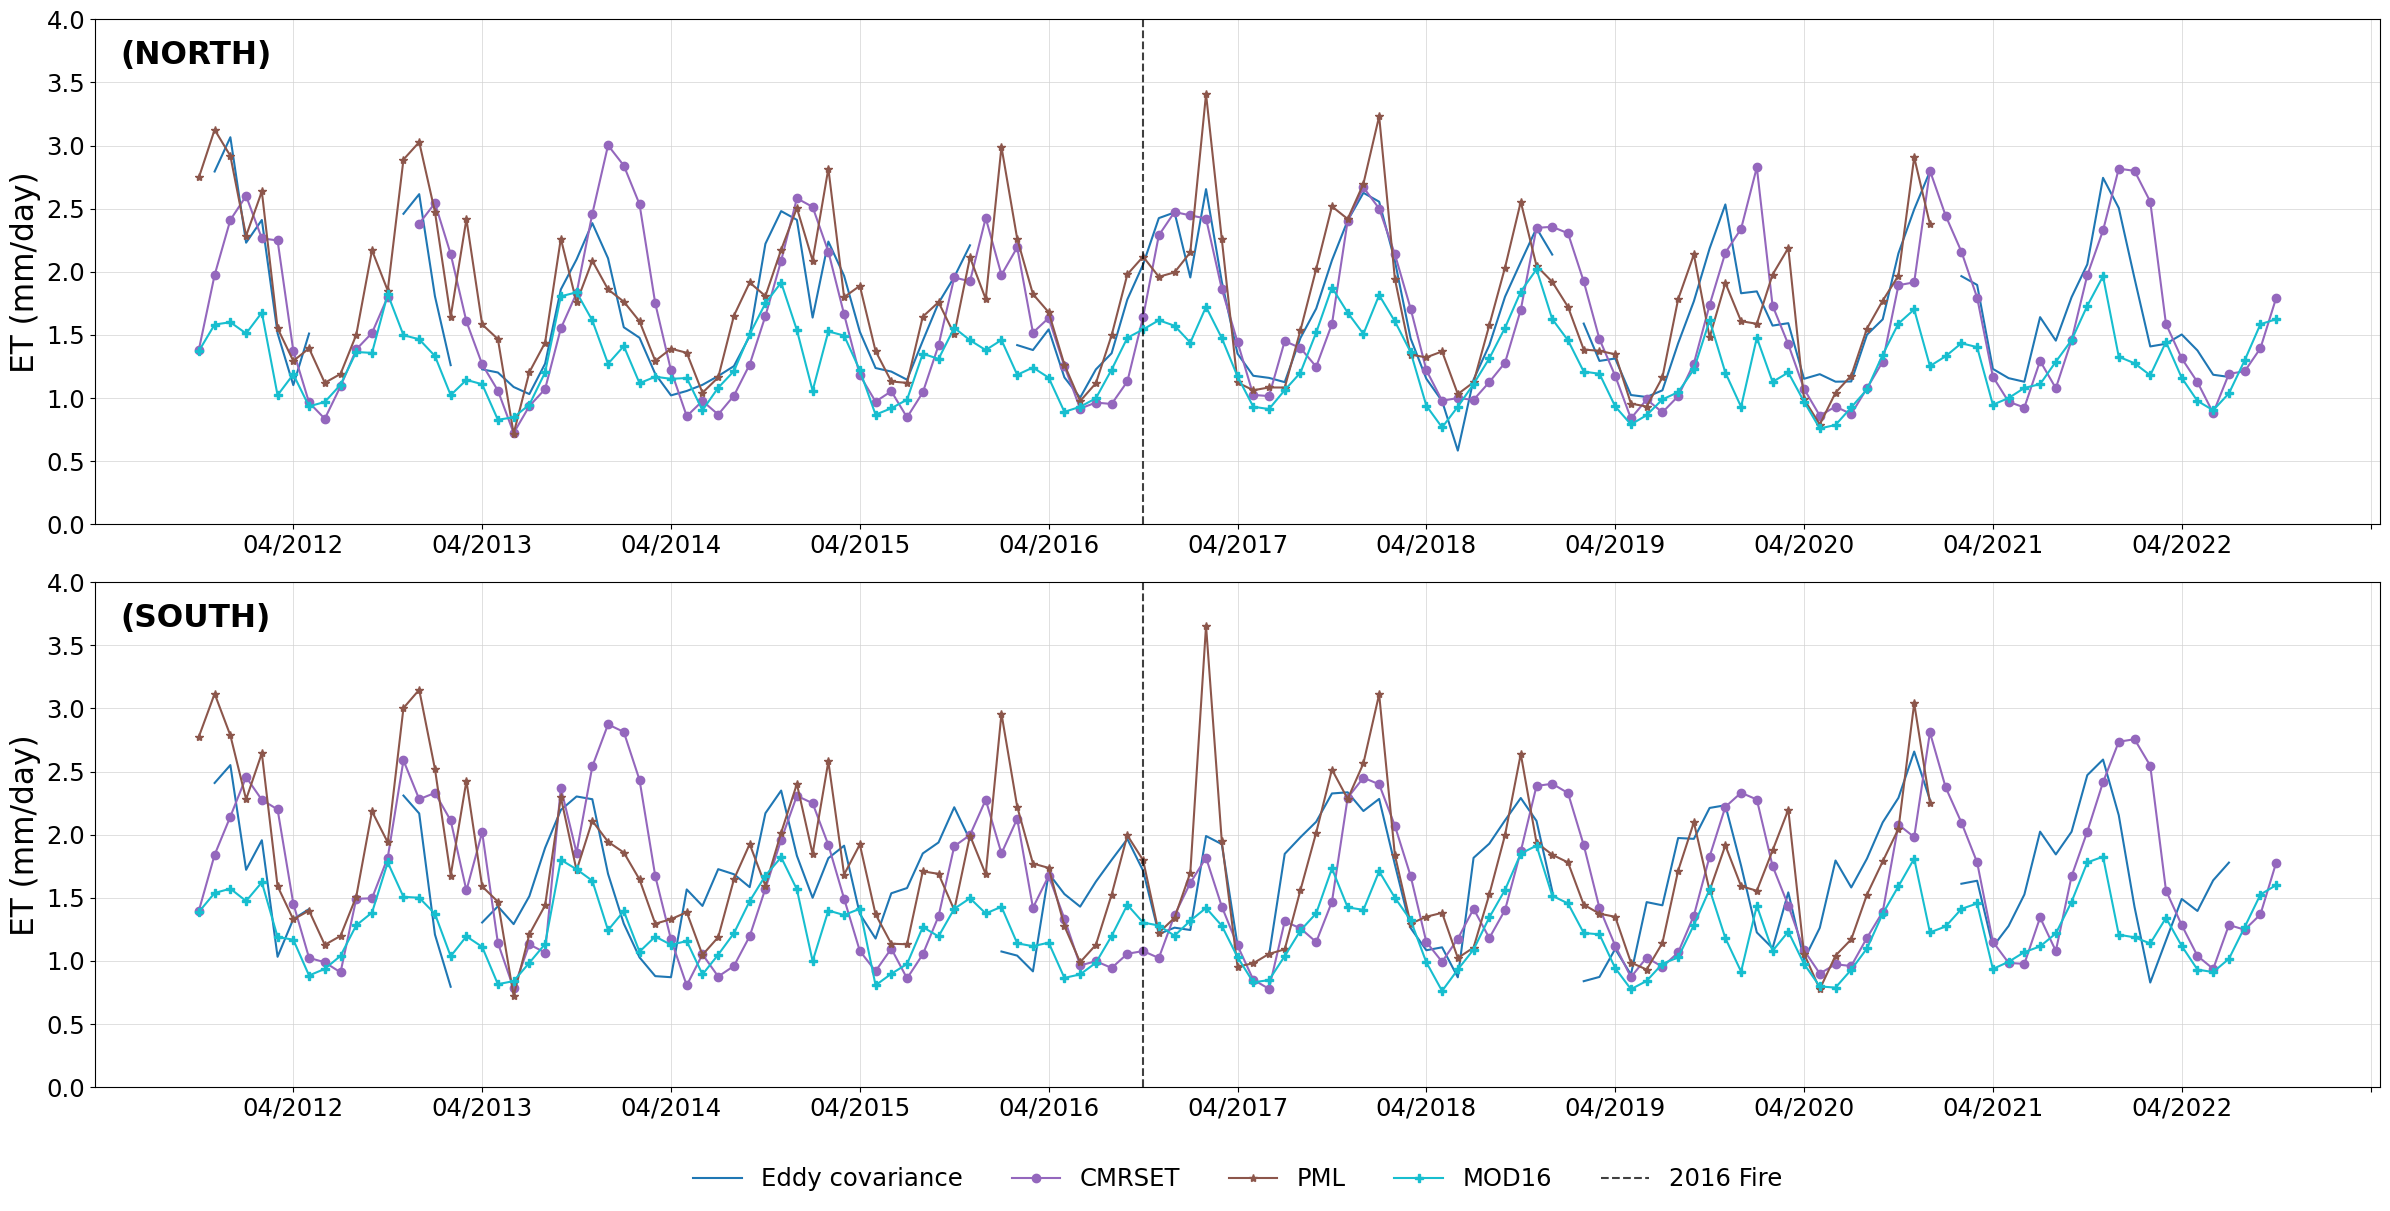

In [ ]:
# Direct north and south plot
plt.figure(figsize=(24,12))

plt.subplot(2,1,1)
plt.plot(combine_N.index.to_series().dt.strftime('%m/%Y'),combine_N['EC'],label='Eddy covariance',color='tab:blue')
plt.plot(combine_N.index.to_series().dt.strftime('%m/%Y'),combine_N['CMRSET'],label='CMRSET',marker='o',color='tab:purple',alpha=1)
plt.plot(combine_N.index.to_series().dt.strftime('%m/%Y'),combine_N['PML'],label='PML',marker='*',color='tab:brown',alpha=1)
plt.plot(combine_N.index.to_series().dt.strftime('%m/%Y'),combine_N['MOD16'],label='MOD16',marker='P',color='tab:cyan',alpha=1)
plt.axvline(x=dt.datetime(2016,10,1).strftime('%m/%Y'),linestyle='--',linewidth=1.5,c='black',alpha=0.75,label='2016 Fire')
plt.ylim(0.,4.0)
plt.xticks(np.arange(6,len(combine_N.index)+12,12),fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.grid(color='lightgray',linewidth=0.5)
plt.text(-5,3.65,'(NORTH)',fontsize=22.5,fontweight='bold')
plt.ylabel('ET (mm/day)',fontsize=22.5)

plt.subplot(2,1,2)
plt.plot(combine_S.index.to_series().dt.strftime('%m/%Y'),combine_S['EC'],label='Eddy covariance',color='tab:blue')
plt.plot(combine_S.index.to_series().dt.strftime('%m/%Y'),combine_S['CMRSET'],label='CMRSET',marker='o',color='tab:purple',alpha=1)
plt.plot(combine_S.index.to_series().dt.strftime('%m/%Y'),combine_S['PML'],label='PML',marker='*',color='tab:brown',alpha=1)
plt.plot(combine_S.index.to_series().dt.strftime('%m/%Y'),combine_S['MOD16'],label='MOD16',marker='P',color='tab:cyan',alpha=1)
plt.axvline(x=dt.datetime(2016,10,1).strftime('%m/%Y'),linestyle='--',linewidth=1.5,c='black',alpha=0.75,label='2016 Fire')
plt.ylim(0.,4.0)
plt.ylabel('ET (mm/day)',fontsize=22.5)
plt.yticks(fontsize=17.5)
plt.xticks(np.arange(6,len(combine_S.index)+12,12),fontsize=17.5)
plt.text(-5,3.65,'(SOUTH)',fontsize=22.5,fontweight='bold')
plt.grid(color='lightgray',linewidth=0.5)
plt.legend(loc='lower center',ncol=7,fontsize=17.5,bbox_to_anchor=(0.5,-0.25),frameon=False)

plt.tight_layout()
plt.savefig('North - South monthly comparison.png')

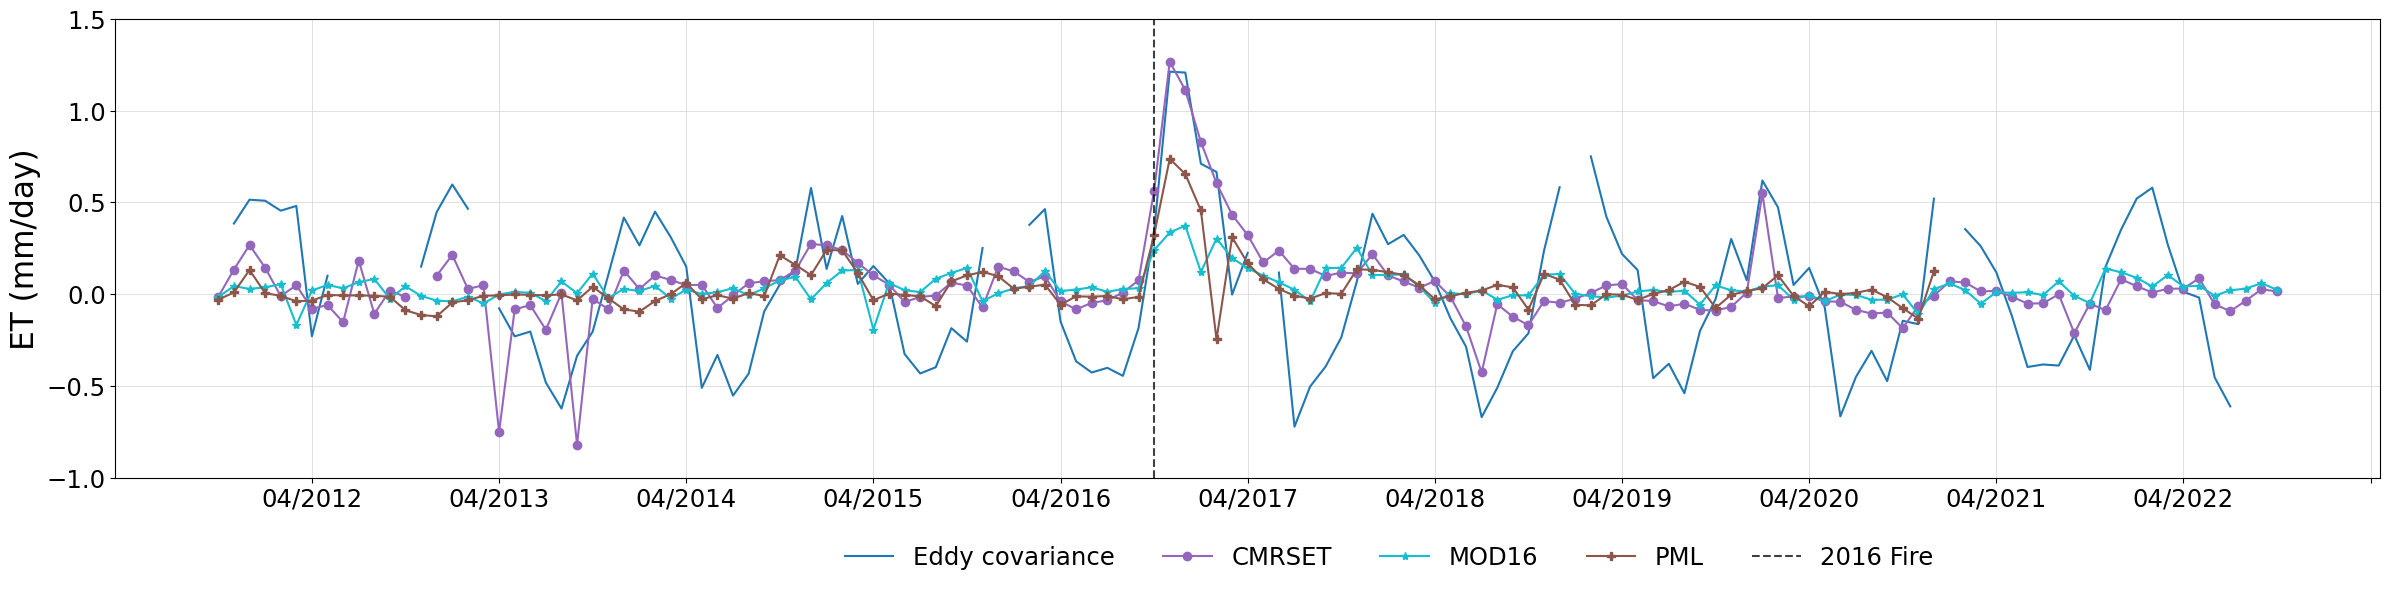

In [ ]:
# Difference
combine_diff = combine_N.drop(columns=['year','month']) - combine_S.drop(columns=['year','month'])

# Ratio
combine_ratio = combine_N.drop(columns=['year','month']) / combine_S.drop(columns=['year','month'])

# CALCULATE DIFFERENCE PRE-FIRE MEAN AND VARIANCE
combine_diff_pre_fire_stat = pd.DataFrame(np.zeros((len(['mean','variance']),len(['EC','CMRSET','MOD16','PML'])))*np.nan,
                                         index=['mean','variance'],columns=['EC','CMRSET','MOD16','PML'])
combine_diff_pre_fire_stat.loc[['mean'],:] = np.array(combine_diff['2011-10-01':'2016-10-01'].mean())
combine_diff_pre_fire_stat.loc[['variance'],:] = np.array(combine_diff['2011-10-01':'2016-10-01'].var())

# CONFUSION MATRIX TYPE REPORT TABLE FOR RMSE

# Combine for loop
combine_rmse_for_loop = [combine_diff['2011-10-01':'2016-10-01'],combine_ratio['2011-10-01':'2016-10-01']]

# Empty dfs for report
combine_diff_rmse = pd.DataFrame(np.zeros((len(['EC','CMRSET','MOD16','PML']),len(['EC','CMRSET','MOD16','PML'])))*np.nan,
                                 index=['EC','CMRSET','MOD16','PML'],columns=['EC','CMRSET','MOD16','PML'])
combine_ratio_rmse = combine_diff_rmse.copy()
combine_rmse = [combine_diff_rmse,combine_ratio_rmse]

# Loop
for x in range(len(combine_rmse_for_loop)):
    
    # Select which dataframe for further steps
    combine_x = combine_rmse_for_loop[x]
    
    for y in range(len(combine_x.columns)):
        
        # Bring the needed column up front
        combine_x_y = combine_x.copy()
        
        combine_x_y.insert(0,combine_x_y.columns[y],combine_x_y.pop(combine_x_y.columns[y]))
        
        for z in range(len(combine_x_y.columns)):
            
            if z == 0:
                
                # Calculate rmse of the needed column with the others:
                rmse_ = rmse_fnc(combine_x_y[combine_x_y.columns[0]].dropna(axis=0),combine_x_y[combine_x_y.columns[0]].dropna(axis=0))
            
                # Report
                combine_rmse[x][combine_x_y.columns[0]][combine_x_y.columns[0]] = rmse_
                
            else:

                # Calculate rmse of the needed column with the others:
                RMSE_ = rmse_fnc(combine_x_y.loc[:,[combine_x_y.columns[0],combine_x_y.columns[0+z]]].dropna(axis=0)[combine_x_y.columns[0+z]],
                             combine_x_y.loc[:,[combine_x_y.columns[0],combine_x_y.columns[0+z]]].dropna(axis=0)[combine_x_y.columns[0]])
                
                # Report
                combine_rmse[x][combine_x_y.columns[0]][combine_x_y.columns[0+z]] = RMSE_
                
# Export
combine_diff_rmse.to_csv('Comparison difference rmse.csv')
combine_ratio_rmse.to_csv('Comparison ratio rmse.csv')

# STATISTIC OF PRE- AND POST-FIRE DIFF AND RATIO DISTRIBUTION

# Create empty dfs

# Index
entity = ['Diff','Ratio']
period = ['Pre-fire','Post-fire']
metric = ['Mean','Median','Variance']
stat_report_1_index = pd.MultiIndex.from_product([entity,period,metric],names=['Entity','Period','Metric'])

# Dfs
stat_report_1 = pd.DataFrame(np.zeros((len(stat_report_1_index),len(combine_diff.columns)))*np.nan,index=stat_report_1_index,columns=combine_diff.columns)

# Loop
for x in range(len(stat_report_1.columns)):
    stat_report_1[stat_report_1.columns[x]] = np.array([np.mean(combine_diff['2011-10-01':'2016-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.median(combine_diff['2011-10-01':'2016-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.var(combine_diff['2011-10-01':'2016-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.mean(combine_diff['2016-11-01':'2022-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.median(combine_diff['2016-11-01':'2022-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.var(combine_diff['2016-11-01':'2022-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.mean(combine_ratio['2011-10-01':'2016-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.median(combine_ratio['2011-10-01':'2016-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.var(combine_ratio['2011-10-01':'2016-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.mean(combine_ratio['2016-11-01':'2022-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.median(combine_ratio['2016-11-01':'2022-10-01'][stat_report_1.columns[x]].dropna()),
                                                    np.var(combine_ratio['2016-11-01':'2022-10-01'][stat_report_1.columns[x]].dropna())]).reshape(12,1)
stat_report_1.to_csv('Statistic of Diff and Ratio b4 normalisation.csv')

# RESCALE EC

# Inverse ratio
combine_inv_ratio = combine_S.drop(columns=['year','month']) / combine_N.drop(columns=['year','month'])

# Rescale EC south measurements
combine_S_rescaled = combine_S[['year','month']].copy()
combine_S_rescaled['EC'] = combine_N['EC'] * combine_inv_ratio['EC']
combine_S_rescaled['CMRSET'] = combine_N['EC'] * combine_inv_ratio['CMRSET']
combine_S_rescaled['MOD16'] = combine_N['EC'] * combine_inv_ratio['MOD16']
combine_S_rescaled['PML'] = combine_N['EC'] * combine_inv_ratio['PML']

# Rescale difference
combine_diff_rescaled = combine_diff['EC'].copy().to_frame()
combine_diff_rescaled['CMRSET'] = combine_N['EC'] - combine_S_rescaled['CMRSET']
combine_diff_rescaled['MOD16'] = combine_N['EC'] - combine_S_rescaled['MOD16']
combine_diff_rescaled['PML'] = combine_N['EC'] - combine_S_rescaled['PML']

# PLOT
plt.figure(figsize=(24,6))
plt.plot(combine_diff.index.to_series().dt.strftime('%m/%Y'),combine_diff['EC'],label='Eddy covariance',color='tab:blue')
plt.plot(combine_diff.index.to_series().dt.strftime('%m/%Y'),combine_diff['CMRSET'],label='CMRSET',marker='o',color='tab:purple',alpha=1)
plt.plot(combine_diff.index.to_series().dt.strftime('%m/%Y'),combine_diff['MOD16'],label='MOD16',marker='*',color='tab:cyan',alpha=1)
plt.plot(combine_diff.index.to_series().dt.strftime('%m/%Y'),combine_diff['PML'],label='PML',marker='P',color='tab:brown',alpha=1)
plt.axvline(x=dt.datetime(2016,10,1).strftime('%m/%Y'),linestyle='--',linewidth=1.5,c='black',alpha=0.75,label='2016 Fire')
plt.xticks(np.arange(6,len(combine_diff.index)+12,12),fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.ylim(-1,1.5)
plt.grid(color='lightgray',linewidth=0.5)
plt.ylabel('ET (mm/day)',fontsize=22.5)
plt.legend(loc=1,ncol=6,fontsize=17.5,bbox_to_anchor=(0.8125,-0.1),frameon=False)
plt.tight_layout()
plt.savefig('Difference before normalisation.png')

<h2>5. Differences-in-Differences</h2>

In [ ]:
# Combine 'north' and 'south'
combine = [combine_N,combine_S]

# CREATE EMPTY DFS

# Pre- and post-fire data
pre_fire = [[],[]]
post_fire = [[],[]]

# Pre-fire reference
pre_fire_ref = [[],[]]

# Pre- and post-fire normalised
pre_fire_norm = [[],[]]
post_fire_norm = [[],[]]

# LOOP
for x in range(len(combine)):
    
    # Separate to pre- and post-fire 
    pre_fire_x = combine[x]['2011-10-01':'2016-10-01']
    post_fire_x = combine[x]['2016-11-01':'2022-10-01']
    
    # Calculate pre-fire reference
    pre_fire_ref_x = pre_fire_x.groupby(['month'])[['EC','CMRSET','MOD16','PML']].mean()
    
    # Create empty dfs for normalisation
    pre_fire_norm_x = pre_fire_x.loc[:,['year','month']]
    post_fire_norm_x = post_fire_x.loc[:,['year','month']]
    
    # Loop to get normalisation
    for y in range(2,len(pre_fire_x.columns)):
        pre_fire_x_y = pre_fire_x.loc[:,['year','month',pre_fire_x.columns[y]]].reset_index(drop=True)
        post_fire_x_y = post_fire_x.loc[:,['year','month',post_fire_x.columns[y]]].reset_index(drop=True)
        
        pre_fire_ref_x_y = pre_fire_ref_x[pre_fire_x.columns[y]].reset_index()
        d = {1:pre_fire_ref_x_y.iloc[0,1],2:pre_fire_ref_x_y.iloc[1,1],3:pre_fire_ref_x_y.iloc[2,1],4:pre_fire_ref_x_y.iloc[3,1],
             5:pre_fire_ref_x_y.iloc[4,1],6:pre_fire_ref_x_y.iloc[5,1],7:pre_fire_ref_x_y.iloc[6,1],8:pre_fire_ref_x_y.iloc[7,1],
             9:pre_fire_ref_x_y.iloc[8,1],10:pre_fire_ref_x_y.iloc[9,1],11:pre_fire_ref_x_y.iloc[10,1],12:pre_fire_ref_x_y.iloc[11,1]}
        
        pre_fire_x_y['norm '+pre_fire_x.columns[y]] = pre_fire_x_y.month.map(d).sub(pre_fire_x_y.iloc[:,2])
        pre_fire_x_y['norm '+pre_fire_x.columns[y]] = pre_fire_x_y['norm '+pre_fire_x.columns[y]]*(-1)    
        
        post_fire_x_y['norm '+post_fire_x.columns[y]] = post_fire_x_y.month.map(d).sub(post_fire_x_y.iloc[:,2])
        post_fire_x_y['norm '+post_fire_x.columns[y]] = post_fire_x_y['norm '+post_fire_x.columns[y]]*(-1)
        
        pre_fire_x_y_norm = pre_fire_x_y['norm '+pre_fire_x.columns[y]]
        post_fire_x_y_norm = post_fire_x_y['norm '+post_fire_x.columns[y]]
        
        pre_fire_x_y_norm.index = pre_fire_norm_x.index
        post_fire_x_y_norm.index = post_fire_norm_x.index
        
        pre_fire_norm_x = pd.concat([pre_fire_norm_x,pre_fire_x_y_norm],axis=1)
        post_fire_norm_x = pd.concat([post_fire_norm_x,post_fire_x_y_norm],axis=1)
        
    # Report
    pre_fire[x] = pre_fire_x
    pre_fire_ref[x] = pre_fire_ref_x
    pre_fire_norm[x] = pre_fire_norm_x
    
    post_fire[x] = post_fire_x
    post_fire_norm[x] = post_fire_norm_x
    
# Assign dfs
pre_fire_ref_N =  pre_fire_ref[0]
pre_fire_ref_S =  pre_fire_ref[1]
combine_norm_N = pd.concat([pre_fire_norm[0],post_fire_norm[0]])
combine_norm_S = pd.concat([pre_fire_norm[1],post_fire_norm[1]])

# Difference
combine_norm_diff = combine_norm_N.drop(columns=['year','month']) - combine_norm_S.drop(columns=['year','month'])

# Ratio (turn infinite to nan and set a threshold of ratio that equals to absoluate 5)
combine_norm_ratio = (combine_norm_N.drop(columns=['year','month']) / combine_norm_S.drop(columns=['year','month'])).replace([np.inf,-np.inf],np.nan) 
combine_norm_ratio[(combine_norm_ratio > 5) | (combine_norm_ratio < -5)] = np.nan

# STATISTIC OF PRE- AND POST-FIRE NORMALISED DIFF AND RATIO DISTRIBUTION

# Create empty dfs

# Index
entity = ['Diff','Ratio']
period = ['Pre-fire','Post-fire']
metric = ['Mean','Median','Variance']
stat_report_2_index = pd.MultiIndex.from_product([entity,period,metric],names=['Entity','Period','Metric'])

# Dfs
stat_report_2 = pd.DataFrame(np.zeros((len(stat_report_2_index),len(combine_norm_diff.columns)))*np.nan,index=stat_report_2_index,columns=combine_norm_diff.columns)

# Loop
for x in range(len(stat_report_2.columns)):
    stat_report_2[stat_report_2.columns[x]] = np.array([np.mean(combine_norm_diff['2011-10-01':'2016-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.median(combine_norm_diff['2011-10-01':'2016-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.var(combine_norm_diff['2011-10-01':'2016-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.mean(combine_norm_diff['2016-11-01':'2022-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.median(combine_norm_diff['2016-11-01':'2022-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.var(combine_norm_diff['2016-11-01':'2022-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.mean(combine_norm_ratio['2011-10-01':'2016-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.median(combine_norm_ratio['2011-10-01':'2016-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.var(combine_norm_ratio['2011-10-01':'2016-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.mean(combine_norm_ratio['2016-11-01':'2022-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.median(combine_norm_ratio['2016-11-01':'2022-10-01'][stat_report_2.columns[x]].dropna()),
                                                    np.var(combine_norm_ratio['2016-11-01':'2022-10-01'][stat_report_2.columns[x]].dropna())]).reshape(12,1)

stat_report_2.to_csv('Statistic of Difference and Ratio after normalisation.csv')

<h2>6. Hypothesis testing with normalised data</h2>

In [ ]:
# STATISTIC OF PRE- AND POST-FIRE DISTRIBUTION

# Create empty dfs

# Index
site = ['North','South']
period = ['Pre-fire','Post-fire']
metric = ['Mean','Median','Variance']
stat_report_3_index = pd.MultiIndex.from_product([site,period,metric],names=['Site','Period','Metric'])

# Dfs
stat_report_3 = pd.DataFrame(np.zeros((len(stat_report_3_index),len(combine_norm_N.columns)))*np.nan,index=stat_report_3_index,columns=combine_norm_N.columns)

# Loop
for x in range(len(stat_report_3.columns)):
    stat_report_3[stat_report_3.columns[x]] = np.array([np.mean(combine_norm_N['2011-10-01':'2016-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.median(combine_norm_N['2011-10-01':'2016-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.var(combine_norm_N['2011-10-01':'2016-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.mean(combine_norm_N['2016-11-01':'2022-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.median(combine_norm_N['2016-11-01':'2022-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.var(combine_norm_N['2016-11-01':'2022-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.mean(combine_norm_S['2011-10-01':'2016-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.median(combine_norm_S['2011-10-01':'2016-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.var(combine_norm_S['2011-10-01':'2016-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.mean(combine_norm_S['2016-11-01':'2022-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.median(combine_norm_S['2016-11-01':'2022-10-01'][stat_report_3.columns[x]].dropna()),
                                                    np.var(combine_norm_S['2016-11-01':'2022-10-01'][stat_report_3.columns[x]].dropna())]).reshape(12,1)

stat_report_3.to_csv('Statistic of North and South after normalisation.csv')

In [9]:
# CHECK IF FIRE AFFECT NORTH SITE - KRUSKAL-WALLIS TEST (NON PARAMETRIC VERSION OF ANOVA)

for x in range(2,len(combine_norm_N.columns)):
    N_stat_1,N_p_1 = kruskal(combine_norm_N.drop(columns=['year','month'])['2011-10-01':'2016-10-01'][combine_norm_N.columns[x]].dropna(),combine_norm_N.loc['2016-11-01'][combine_norm_N.columns[x]])
    if N_p_1 > 0.05:
        print(stat_report_3.columns[x]+' North: 1 month after the fire, the median of north ET is the same')
    else:
        print(stat_report_3.columns[x]+' North: 1 month after the fire, the median of north ET is not the same')

    # 2 months after the fire
    N_stat_2,N_p_2 = kruskal(combine_norm_N.drop(columns=['year','month'])['2011-10-01':'2016-10-01'][combine_norm_N.columns[x]].dropna(),combine_norm_N['2016-11-01':'2016-12-01'][combine_norm_N.columns[x]])
    if N_p_2 > 0.05:
        print(stat_report_3.columns[x]+' North: 2 months after the fire, the median of north ET is the same')
    else:
        print(stat_report_3.columns[x]+' North: 2 months after the fire, the median of north ET is not the same')

    # 2 months after the fire
    N_stat_3,N_p_3 = kruskal(combine_norm_N.drop(columns=['year','month'])['2011-10-01':'2016-10-01'][combine_norm_N.columns[x]].dropna(),combine_norm_N['2016-11-01':'2017-01-01'][combine_norm_N.columns[x]])
    if N_p_3 > 0.05:
        print(stat_report_3.columns[x]+' North: 3 months after the fire, the median of north ET is the same')
    else:
        print(stat_report_3.columns[x]+' North: 3 months after the fire, the median of north ET is not the same')   

norm EC North: 1 month after the fire, the median of north ET is the same
norm EC North: 2 months after the fire, the median of north ET is the same
norm EC North: 3 months after the fire, the median of north ET is the same
norm CMRSET North: 1 month after the fire, the median of north ET is the same
norm CMRSET North: 2 months after the fire, the median of north ET is the same
norm CMRSET North: 3 months after the fire, the median of north ET is the same
norm MOD16 North: 1 month after the fire, the median of north ET is the same
norm MOD16 North: 2 months after the fire, the median of north ET is the same
norm MOD16 North: 3 months after the fire, the median of north ET is the same
norm PML North: 1 month after the fire, the median of north ET is the same
norm PML North: 2 months after the fire, the median of north ET is the same
norm PML North: 3 months after the fire, the median of north ET is not the same


In [10]:
# TEST FOR TREND POST-FIRE - MANN-KENDALL TREND TEST

for x in range(2,len(combine_norm_N.columns)):
    N_trend = mk.original_test(combine_norm_N.drop(columns=['year','month'])['2016-11-01':'2022-10-01'][combine_norm_N.columns[x]].dropna())
    print(combine_norm_N.columns[x]+' North: ')
    print(N_trend)
    S_trend = mk.original_test(combine_norm_S.drop(columns=['year','month'])['2016-11-01':'2022-10-01'][combine_norm_S.columns[x]].dropna())
    print(combine_norm_N.columns[x]+' South: ')
    print(S_trend)

norm EC North: 
Mann_Kendall_Test(trend='no trend', h=False, p=0.5149894318179338, z=0.6510883881173718, Tau=0.05443371378402107, s=124.0, var_s=35688.666666666664, slope=0.000879437349999998, intercept=-0.00426989347499996)
norm EC South: 
Mann_Kendall_Test(trend='no trend', h=False, p=0.2338361857381246, z=1.190534990596874, Tau=0.09995477159656264, s=221.0, var_s=34147.666666666664, slope=0.002583688060344817, intercept=-0.009836691741379036)
norm CMRSET North: 
Mann_Kendall_Test(trend='no trend', h=False, p=0.5305931142576203, z=0.6271008740159046, Tau=0.05086071987480438, s=130.0, var_s=42316.0, slope=0.0007889188312209234, intercept=-0.031889440757662244)
norm CMRSET South: 
Mann_Kendall_Test(trend='increasing', h=True, p=0.002022611363822868, z=3.086891899225577, Tau=0.24882629107981222, s=636.0, var_s=42316.0, slope=0.005119542793882962, intercept=-0.19903855762566777)
norm MOD16 North: 
Mann_Kendall_Test(trend='no trend', h=False, p=0.1976657456561186, z=-1.2882304776295714, T

In [11]:
# TEST OF NORMALITY FOR N-S DIFFERENCE PRE- AND POST-FIRE DISTRIBUTIONS - SHAPIRO-WILK TEST

for x in range(len(combine_norm_diff.columns)):
    
    # Pre-fire 
    pre_fire_stat, pre_fire_p = shapiro(combine_norm_diff['2016-11-01':'2022-10-01'][combine_norm_diff.columns[x]].dropna())
    
    if pre_fire_p > 0.05:
        print(combine_norm_diff.columns[x]+': Pre-fire difference distribution is normal')
    else:
        print(combine_norm_diff.columns[x]+': Pre-fire difference distribution is not normal')
        
    # Post-fire 
    post_fire_stat, post_fire_p = shapiro(combine_norm_diff['2016-11-01':'2022-10-01'][combine_norm_diff.columns[x]].dropna())
    
    if post_fire_p > 0.05:
        print(combine_norm_diff.columns[x]+': Post-fire difference distribution is normal')
    else:
        print(combine_norm_diff.columns[x]+': Post-fire difference distribution is not normal')

norm EC: Pre-fire difference distribution is not normal
norm EC: Post-fire difference distribution is not normal
norm CMRSET: Pre-fire difference distribution is not normal
norm CMRSET: Post-fire difference distribution is not normal
norm MOD16: Pre-fire difference distribution is not normal
norm MOD16: Post-fire difference distribution is not normal
norm PML: Pre-fire difference distribution is not normal
norm PML: Post-fire difference distribution is not normal


In [12]:
# AS MONTHLY DIFFERENCE PRE AND POST-FIRE DISTRIBUTIONS ARE NORMAL, USE INDEPENDENT T-TEST AND ANOVA TO CHECK N/S DIFFERENCE CHANGE DUE TO FIRE (accumulated time post-fire)

for x in range(len(combine_norm_diff.columns)):
    
    if x == 0: # EC distributions is normal
        
        # STUDENT T-TEST FOR THE SPIKE (THE FIRST YEAR AFTER THE FIRE):
        t_stat_1, t_p_1 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2017-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        # STUDENT T-TEST FOR THE REST:
        t_stat_2, t_p_2 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2018-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_2 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 2nd year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 2nd year post fire, the mean ET difference post-fire is not the same with that pre-fire')

        t_stat_3, t_p_3 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2019-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_3 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 3rd year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 3rd year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        t_stat_4, t_p_4 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2020-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_4 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 4th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 4th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        t_stat_4, t_p_4 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2021-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 5th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 5th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        t_stat_5, t_p_5 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2022-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 6th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 6th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
    else: 

        # ANOVA FOR THE SPIKE (THE FIRST YEAR AFTER THE FIRE):
        anova_stat_1, anova_p_1 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2017-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        # ANOVA FOR THE REST:
        anova_stat_2, anova_p_2 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2018-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_2 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 2nd year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 2nd yearpost fire, the mean ET difference post-fire is not the same with that pre-fire')

        anova_stat_3, anova_p_3 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2019-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_3 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 3rd year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 3rd year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        anova_stat_4, anova_p_4 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2020-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_4 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 4th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 4th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        anova_stat_4, anova_p_4 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2021-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 5th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 5th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        anova_stat_5, anova_p_5 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2022-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st - 6th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st - 6th year post fire, the mean ET difference post-fire is not the same with that pre-fire')

norm EC: 1st year post fire, the mean ET difference post-fire is not the same with that pre-fire
norm EC: 1st - 2nd year post-fire, the mean ET difference post-fire is the same with that pre-fire
norm EC: 1st - 3rd year post-fire, the mean ET difference post-fire is the same with that pre-fire
norm EC: 1st - 4th year post-fire, the mean ET difference post-fire is the same with that pre-fire
norm EC: 1st - 5th year post fire, the mean ET difference post-fire is not the same with that pre-fire
norm EC: 1st - 6th year post fire, the mean ET difference post-fire is not the same with that pre-fire
norm CMRSET: 1st year post fire, the mean ET difference post-fire is not the same with that pre-fire
norm CMRSET: 1st - 2nd yearpost fire, the mean ET difference post-fire is not the same with that pre-fire
norm CMRSET: 1st - 3rd year post fire, the mean ET difference post-fire is not the same with that pre-fire
norm CMRSET: 1st - 4th year post-fire, the mean ET difference post-fire is the same wi

In [13]:
# AS MONTHLY DIFFERENCE PRE AND POST-FIRE DISTRIBUTIONS ARE NORMAL, USE INDEPENDENT T-TEST AND ANOVA TO CHECK N/S DIFFERENCE CHANGE DUE TO FIRE (separated time post-fire)

for x in range(len(combine_norm_diff.columns)):
    
    if x == 0: # EC distributions is normal
        
        # STUDENT T-TEST FOR THE SPIKE (THE FIRST YEAR AFTER THE FIRE):
        t_stat_1, t_p_1 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2017-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        # STUDENT T-TEST FOR THE REST:
        t_stat_2, t_p_2 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2017-11-01':'2018-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_2 > 0.05:
            print(combine_norm_diff.columns[x]+': 2nd year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 2nd year post fire, the mean ET difference post-fire is not the same with that pre-fire')

        t_stat_3, t_p_3 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2018-11-01':'2019-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_3 > 0.05:
            print(combine_norm_diff.columns[x]+': 3rd year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 3rd year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        t_stat_4, t_p_4 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2019-11-01':'2020-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_4 > 0.05:
            print(combine_norm_diff.columns[x]+': 4th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 4th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        t_stat_4, t_p_4 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2020-11-01':'2021-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 5th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 5th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        t_stat_5, t_p_5 = ttest_ind(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2021-11-01':'2022-10-01'][combine_norm_diff.columns[x]].dropna())
        if t_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 6th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 6th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
    else: 

        # ANOVA FOR THE SPIKE (THE FIRST YEAR AFTER THE FIRE):
        anova_stat_1, anova_p_1 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2016-11-01':'2017-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 1st year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 1st year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        # ANOVA FOR THE REST:
        anova_stat_2, anova_p_2 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2017-11-01':'2018-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_2 > 0.05:
            print(combine_norm_diff.columns[x]+': 2nd year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 2nd yearpost fire, the mean ET difference post-fire is not the same with that pre-fire')

        anova_stat_3, anova_p_3 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2018-11-01':'2019-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_3 > 0.05:
            print(combine_norm_diff.columns[x]+': 3rd year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 3rd year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        anova_stat_4, anova_p_4 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2019-11-01':'2020-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_4 > 0.05:
            print(combine_norm_diff.columns[x]+': 4th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 4th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        anova_stat_4, anova_p_4 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2020-11-01':'2021-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 5th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 5th year post fire, the mean ET difference post-fire is not the same with that pre-fire')
            
        anova_stat_5, anova_p_5 = f_oneway(combine_norm_diff['2011-10-01':'2016-10-01'][combine_norm_diff.columns[x]].dropna(),combine_norm_diff['2021-11-01':'2022-10-01'][combine_norm_diff.columns[x]].dropna())
        if anova_p_1 > 0.05:
            print(combine_norm_diff.columns[x]+': 6th year post-fire, the mean ET difference post-fire is the same with that pre-fire')
        else:
            print(combine_norm_diff.columns[x]+': 6th year post fire, the mean ET difference post-fire is not the same with that pre-fire')

norm EC: 1st year post fire, the mean ET difference post-fire is not the same with that pre-fire
norm EC: 2nd year post-fire, the mean ET difference post-fire is the same with that pre-fire
norm EC: 3rd year post-fire, the mean ET difference post-fire is the same with that pre-fire
norm EC: 4th year post-fire, the mean ET difference post-fire is the same with that pre-fire
norm EC: 5th year post fire, the mean ET difference post-fire is not the same with that pre-fire
norm EC: 6th year post fire, the mean ET difference post-fire is not the same with that pre-fire
norm CMRSET: 1st year post fire, the mean ET difference post-fire is not the same with that pre-fire
norm CMRSET: 2nd year post-fire, the mean ET difference post-fire is the same with that pre-fire
norm CMRSET: 3rd year post-fire, the mean ET difference post-fire is the same with that pre-fire
norm CMRSET: 4th year post-fire, the mean ET difference post-fire is the same with that pre-fire
norm CMRSET: 5th year post fire, the m

<h2>7. Visualise normalised data</h2>

In [ ]:
# Set year and month for norm diff and norm ratio
combine_norm_diff = pd.concat([combine_norm_N[['year','month']],combine_norm_diff],axis=1)
combine_norm_ratio = pd.concat([combine_norm_S[['year','month']],combine_norm_ratio],axis=1)

# Separate norm diff to pre- and post-fire
combine_norm_diff_pre_fire = combine_norm_diff['2011-10-01':'2016-10-01']
combine_norm_diff_post_fire = combine_norm_diff['2016-11-01':'2022-10-01']

# POST-FIRE ACCUMULATION
combine_norm_diff_pre_fire_accu = combine_norm_diff_pre_fire[['year','month']].copy()
combine_norm_diff_pre_fire_accu[['norm EC','norm CMRSET','norm MOD16','norm PML']] = np.nan

# POST-FIRE ACCUMULATION
combine_norm_diff_post_fire_vol = combine_norm_diff_post_fire[['year','month']].copy().reset_index(drop=True)

# Number of day
combine_norm_diff_post_fire_vol['no of day'] = np.nan

for x in range(len(combine_norm_diff_post_fire_vol)):
    combine_norm_diff_post_fire_vol.iloc[x,2] = monthrange(combine_norm_diff_post_fire_vol.iloc[x,0],combine_norm_diff_post_fire_vol.iloc[x,1])[1]

combine_norm_diff_post_fire_vol['norm EC'] = combine_norm_diff_post_fire.reset_index(drop=True)['norm EC'] * combine_norm_diff_post_fire_vol['no of day']
combine_norm_diff_post_fire_vol['norm CMRSET'] = combine_norm_diff_post_fire.reset_index(drop=True)['norm CMRSET'] * combine_norm_diff_post_fire_vol['no of day']
combine_norm_diff_post_fire_vol['norm MOD16'] = combine_norm_diff_post_fire.reset_index(drop=True)['norm MOD16'] * combine_norm_diff_post_fire_vol['no of day']
combine_norm_diff_post_fire_vol['norm PML'] = combine_norm_diff_post_fire.reset_index(drop=True)['norm PML'] * combine_norm_diff_post_fire_vol['no of day']

combine_norm_diff_post_fire_accu = combine_norm_diff_post_fire_vol[['norm EC','norm CMRSET','norm MOD16','norm PML']].cumsum(skipna=True,axis=0)
combine_norm_diff_post_fire_accu = pd.concat([combine_norm_diff_post_fire_vol[['year','month']],combine_norm_diff_post_fire_accu],axis=1).set_index(combine_norm_diff_post_fire.index)
combine_norm_diff_accu = pd.concat([combine_norm_diff_pre_fire_accu,combine_norm_diff_post_fire_accu])

combine_norm_diff.to_csv('Normalised difference.csv')
combine_norm_diff_accu.to_csv('Normalised accumulated difference.csv')

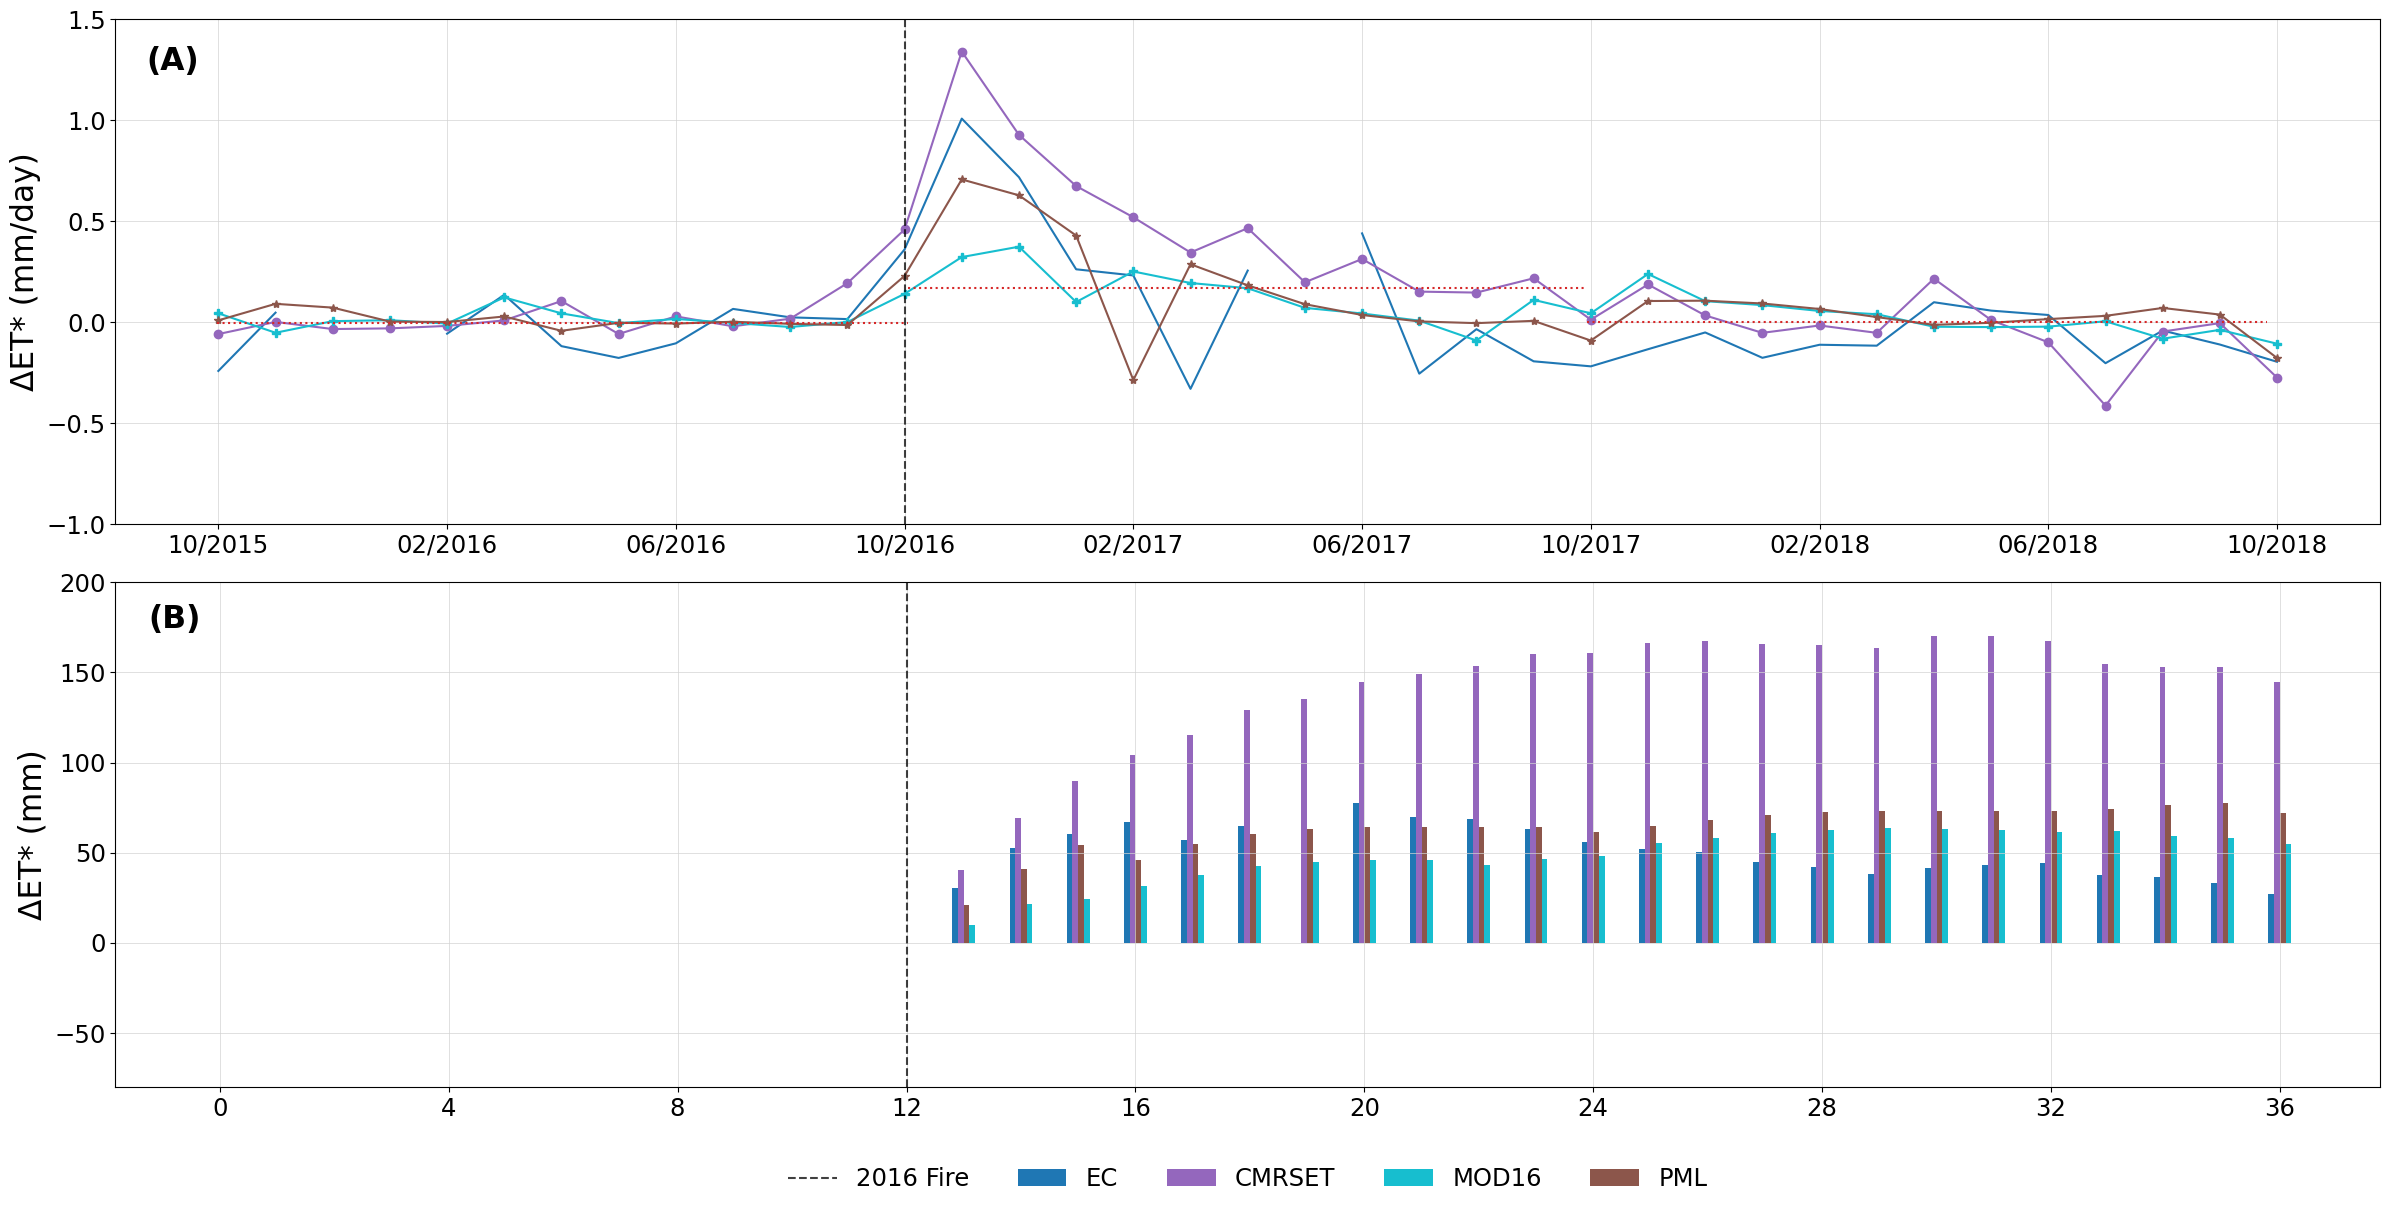

In [ ]:
# Plot
plt.figure(figsize=(24,12))

bar_plot_x_axis = np.arange(len(combine_norm_diff_accu['2015-10-01':'2018-10-01'].index))
plt.subplot(2,1,1)
plt.plot(combine_norm_diff['2015-10-01':'2018-10-01'].index.to_series().dt.strftime('%m/%Y'),combine_norm_diff['2015-10-01':'2018-10-01']['norm EC'],label='Eddy covariance',color='tab:blue')
plt.plot(combine_norm_diff['2015-10-01':'2018-10-01'].index.to_series().dt.strftime('%m/%Y'),combine_norm_diff['2015-10-01':'2018-10-01']['norm CMRSET'],label='CMRSET',marker='o',color='tab:purple',alpha=1)
plt.plot(combine_norm_diff['2015-10-01':'2018-10-01'].index.to_series().dt.strftime('%m/%Y'),combine_norm_diff['2015-10-01':'2018-10-01']['norm MOD16'],label='MOD16',marker='P',color='tab:cyan',alpha=1)
plt.plot(combine_norm_diff['2015-10-01':'2018-10-01'].index.to_series().dt.strftime('%m/%Y'),combine_norm_diff['2015-10-01':'2018-10-01']['norm PML'],label='PML',marker='*',color='tab:brown',alpha=1)
plt.axvline(x=dt.datetime(2016,10,1).strftime('%m/%Y'),linestyle='--',linewidth=1.5,c='black',alpha=0.75,label='2016 Fire')
plt.axhline(y=np.mean(combine_norm_diff_pre_fire['norm EC']),xmin=0.045,xmax=0.35,linestyle=':',linewidth=1.5,c='tab:red',label='Mean value')
plt.axhline(y=np.mean(combine_norm_diff_post_fire['2016-11-01':'2017-10-01']['norm EC']),xmin=0.35,xmax=0.65,linestyle=':',linewidth=1.5,c='tab:red')
plt.axhline(y=np.mean(combine_norm_diff_post_fire['2017-11-01':'2019-10-01']['norm EC']),xmin=0.65,xmax=0.95,linestyle=':',linewidth=1.5,c='tab:red')
plt.ylim(-1,1.5)
plt.ylabel('ΔET* (mm/day)',fontsize=22.5)
plt.yticks(fontsize=17.5)
plt.xticks(np.arange(0,len(combine_norm_diff['2015-10-01':'2018-10-01'].index)+1,4),fontsize=17.5)
plt.text(-1.25,1.25,'(A)',fontsize=22.5,fontweight='bold')
plt.grid(color='lightgray',linewidth=0.5)
# plt.legend(loc='lower center',ncol=7,fontsize=17.5,bbox_to_anchor=(0.5,-0.25),frameon=False)

plt.subplot(2,1,2)
plt.bar(bar_plot_x_axis - 0.15, combine_norm_diff_accu['2015-10-01':'2018-10-01']['norm EC'],0.1, label = 'EC',color='tab:blue')
plt.bar(bar_plot_x_axis - 0.05, combine_norm_diff_accu['2015-10-01':'2018-10-01']['norm CMRSET'],0.1, label = 'CMRSET',color='tab:purple',alpha=1)
plt.bar(bar_plot_x_axis + 0.15, combine_norm_diff_accu['2015-10-01':'2018-10-01']['norm MOD16'],0.1, label = 'MOD16',color='tab:cyan',alpha=1)
plt.bar(bar_plot_x_axis + 0.05, combine_norm_diff_accu['2015-10-01':'2018-10-01']['norm PML'],0.1, label = 'PML',color='tab:brown',alpha=1)
plt.axvline(x=12,linestyle='--',linewidth=1.5,c='black',alpha=0.75,label='2016 Fire')
plt.ylabel('ΔET* (mm)',fontsize=22.5)
plt.ylim(-80,200)
plt.xlim(-1.825,37.75)
plt.yticks(fontsize=17.5)
plt.xticks(np.arange(0,len(combine_norm_diff['2015-10-01':'2018-10-01'].index)+1,4),fontsize=17.5)
plt.text(-1.25,175,'(B)',fontsize=22.5,fontweight='bold')
plt.grid(color='lightgray',linewidth=0.5)
plt.legend(loc='lower center',ncol=7,fontsize=17.5,bbox_to_anchor=(0.5,-0.25),frameon=False)

plt.tight_layout()
plt.savefig('Hypothesis testing and quantified North-South difference (EC - RS).png')